<h1><center> Lab 6 - JPEG Compressionend </center></h1>

## Goal: Introduction of principles of the JPEG baseline coding system.

Import the necessary libraries:

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform,io,util,img_as_ubyte
from skimage import restoration
from skimage import color
import sys
import math
from PIL import Image
from scipy import fftpack
import random

help functions: 

In [2]:
#supplied functions
def load_quantization_table(quality,block_size):
    q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])* quality  # JPEG normalizing array and zig-zag reordering
    if block_size == 4:
        q= (np.round(transform.resize(q,(4,4), preserve_range =True))).astype(np.uint32)
    if block_size == 16:
        q= (np.round(transform.resize(q,(16,16), preserve_range =True))).astype(np.uint32)
    
#     print(q)
#     print(q.dtype)
    
    return q

def quantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return np.array((block / q).round().astype(np.int32))

def dequantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return block * q

def block_to_zigzag(block, order):
    flat_bloack = block.flatten()
    reorder_flat_block = np.array([flat_bloack[int(point)] for point in order])
    return reorder_flat_block
    
def zigzag_to_block(zigzag, order):
     # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))
    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")
    
    block = np.empty((rows*cols), np.int32)

    for i, point in enumerate(order):
        block[int(point)] = zigzag[i]
    return block.reshape((rows,cols))

def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')

def idct_2d(image):
    block = fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')
    block[block>127] =127
    return block

zigzag_order_8x8 = [ 0 , 8 , 1 , 2 ,9 ,16, 24, 17, 10 , 3 , 4, 11 ,18, 25, 32,
         40 ,33, 26, 19, 12 , 5 , 6 ,13 ,20 ,27, 34, 41, 48, 56 ,49,
         42, 35, 28, 21 ,14,  7,15 ,22 ,29 ,36, 43, 50,57, 58, 51 ,
         44, 37, 30, 23, 31, 38, 45, 52, 59, 60, 53, 46, 39, 47, 54 ,
         61, 62, 55 ,63]


Load and show the image of your choice.

Image shape:(512L, 512L), Image data type:uint32


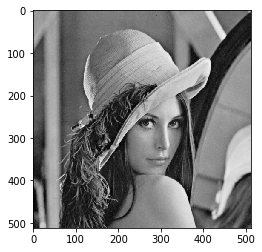

In [3]:
img = io.imread('lena.gif')
img = np.uint32(img_as_ubyte(img))
print ("Image shape:{}, Image data type:{}".format(img.shape,img.dtype))
plt.imshow(img, cmap='gray')
plt.show()

 For each image perform the following tasks:

1. Compress the image using the JPEG compression algorithm (use the supplied function *im2jpeg*). Restore the image from its compressed form using the supplied program *jpeg2im*.   
    * Explain why blocking effects can be seen in the restored image.   
    * Show the blocking effects by zoom in for intresting parrts of the image (use pycharm or crop the image and plot it separatly).

In [4]:
#supplied functions
# im2jpeg Compresses an image using a JPEG approximation.
# im2jpeg(img,block_size, quality) compresses image based on 8 x 8 DCT transforms and coefficient quantization.
# Input quality determines the amount of information that is lost and compression achieved. 

def im2jpeg(img, block_size=8, quality = 1):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint32: 
        print "The input must be a UINT32 image."
        return
    rows, cols = img.shape[0], img.shape[1]
    # block size: (block_size x block_size)
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of {}".format(block_size)))

    # End-Of-Block (EOB) symbol
    eob = 256
    jpeg_list = list()
    # find the zigzag order
    if block_size == 8:
        order  = zigzag_order_8x8
        
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

                # split block_size x block_size block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = (img[i:i+block_size, j:j+block_size] - 128).astype(np.int32)
                # dct to the block
                dct_matrix = dct_2d(block)
                # quantize with quality factor
                quant_matrix = quantize(dct_matrix,quality,block_size)
                # reorder
                zz = block_to_zigzag(quant_matrix, order)
                # find the last non zero element
                last_non_zero = np.flatnonzero(zz)
                if last_non_zero.size == 0: # if all the block is zeros
                    last_non_zero = 0
                else:
                    last_non_zero = last_non_zero[-1]
                zz_no_zeros = np.zeros(last_non_zero+2,dtype=np.int32)
                zz_no_zeros[:last_non_zero+1] = zz[:last_non_zero+1]
                # add eob in the end of the block
                zz_no_zeros[last_non_zero+1] = eob
                # append the dct block to the list
                jpeg_list.append(zz_no_zeros)
                
    #convert the list to array
    jpeg_array = np.concatenate(jpeg_list,axis=None)
    return jpeg_array

# jpeg2im Decodes an IM2JPEG compressed image.
# jpeg2im(jpeg_img) decodes compressed image jpeg_img, generating reconstructed approximation X. 
# jpeg_img is generated by im2jpeg.
def jpeg2im(jpeg_img, block_size=8, quality = 1):
    eob = 256
    # find the zigzag order
    if block_size == 8:
        order  = zigzag_order_8x8

    # find the End-Of-Block (EOB) symbols
    ends_of_blocks = np.where(jpeg_img == eob)[0]
    num_of_block = ends_of_blocks.shape[0]
    # assuming that the image height and width are equal
    image_side = int(math.sqrt(num_of_block)) * block_size
    blocks_per_line = image_side // block_size
    # create new empty image: 
    npmat = np.empty((image_side, image_side), dtype=np.int32)
    start = 0
    for block_index, end in enumerate(ends_of_blocks):
        zigzag = np.zeros(block_size*block_size)
        zigzag[:end-start] = jpeg_img[start:end]
        quant_matrix = zigzag_to_block(zigzag, order)
        dct_matrix = dequantize(quant_matrix,quality,block_size)
        block = idct_2d(dct_matrix)
        # find the place in the image to put the block
        i = (block_index // blocks_per_line * block_size) 
        j = (block_index % blocks_per_line * block_size)
        npmat[i:i+block_size, j:j+block_size] = block + 128
        start = end + 1
    
    return npmat
    

Text(0.5,1,'Zoom in result')

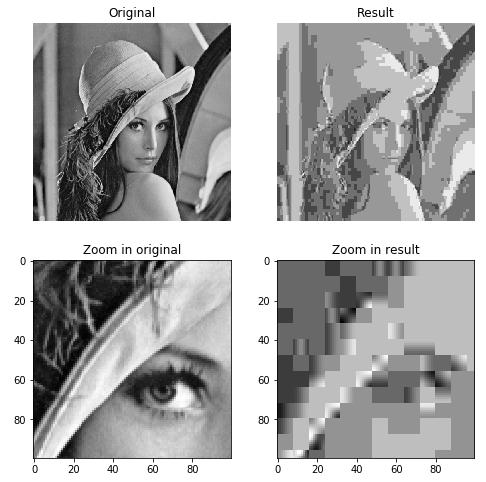

In [5]:
result = jpeg2im(im2jpeg(img,quality=25),quality=25)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0,0].imshow(img,cmap='gray')
ax[0,0].set_title('Original'), ax[0,0].axis('off')
ax[0,1].imshow(result,cmap='gray')
ax[0,1].set_title('Result'), ax[0,1].axis('off')
ax[1,0].imshow(img[200:300,200:300],cmap='gray')
ax[1,0].set_title('Zoom in original')
ax[1,1].imshow(result[200:300,200:300],cmap='gray')
ax[1,1].set_title('Zoom in result')

אלגוריתם הדחיסה ממצע פיקסלים בכל בלוק לערך יחיד, ולכן פיקסלים מסוימים בתמונה המשוחזרת משנים את ערכם לעומת ערכם בתמונה המקורית. לכן ניתן לראות אפקטים של בלוקים בתמונת המקור

2. Plot the graph of compression ratio (Y axis) versus a “quality” parameter of *im2jpeg* (X axis). Use the supplied function *imratio*.  

__Remark:__ the “quality” parameter defines the quality of compression and not the quality of restoration. It is more (or equal) than 1. The “quality” equal to 1 corresponds to the best quality of restoration and the worst quality of compression.


In [5]:
#supplied function
def imratio(original_img1,compressed_img2):
    return float(compressed_img2.nbytes)/original_img1.nbytes

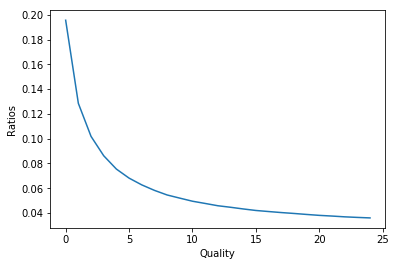

In [6]:
ratios, quality = [], []
for i in range (0,25):
    ratios.append(imratio(img,im2jpeg(img,quality=i+1)))
    quality.append(i)
plt.plot(quality, ratios)
plt.xlabel('Quality')
plt.ylabel('Ratios')
plt.show()

as we increas the quality parameter the ratio parameter decreases since the compressed image's weight (in terms of bytes) is lower, because less data is used.

3. The Root Mean Square (RMS) error of restoration is defined in the following way:  
\begin{equation*}
RMS = \left( \frac{1}{MN}  \sum_{k=0}^{M-1} \sum_{k=0}^{N-1} (\hat{f}(i,j)-f(i,j))^2 \right)^{0.5}
\end{equation*}

    where $f(i, j)$ is the original image, $\hat{f}(i,j)$ is the restored image and $M \times N$ is the size of both images.    
    
    Plot the graph of Root Mean Square (RMS) Error of restoration (Y axis) versus compression ratio (X axis). This graph is called Rate-Distortion curve.  
    
__Hint__: you can use the supplied functions *imratio*.



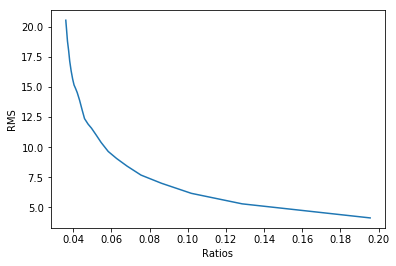

In [7]:
result_array, rms = [], []
n,m = img.shape
for i in range (0,25):
    result_array.append(jpeg2im(im2jpeg(img,quality=i+1),quality=i+1))
    rms.append(np.sqrt((np.sum(np.square(img - result_array[i])))/(n*m)))
plt.plot(ratios, rms)
plt.xlabel('Ratios')
plt.ylabel('RMS')
plt.show()

small ratios shows greater loseד of data which results in a higher RMS.

4.	Repeat question 1 for block sizes __4X4__ and __16X16__. Use the function __*def zigzag_func(M, N)*__  that you wrote for the preliminary report. 
    * Compare blocking effects for different block sizes.   
    * Compare the performance of the algorithm for different block sizes.   
    * What are the advantages and disadvantages of changing the block size? 
    * Resize q array - use *tranform.resize* 
    
__Hint__: you also have to change the quantization matrix m and a block size in the functions *im2jpeg* and *jpeg2im*. 


In [8]:
def zigzag_func(rows, cols):
    size = rows*cols
    matrix = np.zeros((rows,cols))
    arr=[]
    k=0
    for i in range(rows):
        for j in range(cols):
            matrix[i][j] = k
            k = k+1
    solution=[[] for i in range(rows+cols-1)]  
    for i in range(rows): 
        for j in range(cols): 
            sum=i+j 
            if(sum%2 ==0):  
                solution[sum].append(matrix[i][j]) 
            else: 
                solution[sum].insert(0,matrix[i][j]) 
    for i in solution: 
        for j in i: 
            arr.append(j)
    return arr

zigzag_order_4X4 = zigzag_func(4,4)
zigzag_order_16X16 = zigzag_func(16,16)


# im2jpeg Compresses an image using a JPEG approximation.
# im2jpeg(img,block_size, quality) compresses image based on 8 x 8 DCT transforms and coefficient quantization.
# Input quality determines the amount of information that is lost and compression achieved. 

def im2jpeg(img, block_size, quality = 1):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint32: 
        print "The input must be a UINT32 image."
        return
    rows, cols = img.shape[0], img.shape[1]
    # block size: (block_size x block_size)
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of {}".format(block_size)))

    # End-Of-Block (EOB) symbol
    eob = 256
    jpeg_list = list()
    # find the zigzag order
    if block_size == 8:
        order  = zigzag_order_8x8
    else:
        if block_size == 4:
            order= zigzag_order_4X4
        else:
            order = zigzag_order_16X16
            
        
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

                # split block_size x block_size block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = (img[i:i+block_size, j:j+block_size] - 128).astype(np.int32)
                # dct to the block
                dct_matrix = dct_2d(block)
                # quantize with quality factor
                quant_matrix = quantize(dct_matrix,quality,block_size)
                # reorder
                zz = block_to_zigzag(quant_matrix, order)
                # find the last non zero element
                last_non_zero = np.flatnonzero(zz)
                if last_non_zero.size == 0: # if all the block is zeros
                    last_non_zero = 0
                else:
                    last_non_zero = last_non_zero[-1]
                zz_no_zeros = np.zeros(last_non_zero+2,dtype=np.int32)
                zz_no_zeros[:last_non_zero+1] = zz[:last_non_zero+1]
                # add eob in the end of the block
                zz_no_zeros[last_non_zero+1] = eob
                # append the dct block to the list
                jpeg_list.append(zz_no_zeros)
                
    #convert the list to array
    jpeg_array = np.concatenate(jpeg_list,axis=None)
    return jpeg_array

# jpeg2im Decodes an IM2JPEG compressed image.
# jpeg2im(jpeg_img) decodes compressed image jpeg_img, generating reconstructed approximation X. 
# jpeg_img is generated by im2jpeg.
def jpeg2im(jpeg_img, block_size, quality = 1):
    eob = 256
    # find the zigzag order
    if block_size == 8:
        order  = zigzag_order_8x8
    else:
        if block_size == 4:
            order= zigzag_order_4X4
        else:
            order = zigzag_order_16X16
        

    # find the End-Of-Block (EOB) symbols
    ends_of_blocks = np.where(jpeg_img == eob)[0]
    num_of_block = ends_of_blocks.shape[0]
    # assuming that the image height and width are equal
    image_side = int(math.sqrt(num_of_block)) * block_size
    blocks_per_line = image_side // block_size
    # create new empty image: 
    npmat = np.empty((image_side, image_side), dtype=np.int32)
    start = 0
    for block_index, end in enumerate(ends_of_blocks):
        zigzag = np.zeros(block_size*block_size)
        zigzag[:end-start] = jpeg_img[start:end]
        quant_matrix = zigzag_to_block(zigzag, order)
        dct_matrix = dequantize(quant_matrix,quality,block_size)
        block = idct_2d(dct_matrix)
        # find the place in the image to put the block
        i = (block_index // blocks_per_line * block_size) 
        j = (block_index % blocks_per_line * block_size)
        npmat[i:i+block_size, j:j+block_size] = block + 128
        start = end + 1
    
    return npmat



C:\Users\matan\Anaconda2\envs\bluebanana\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\matan\Anaconda2\envs\bluebanana\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


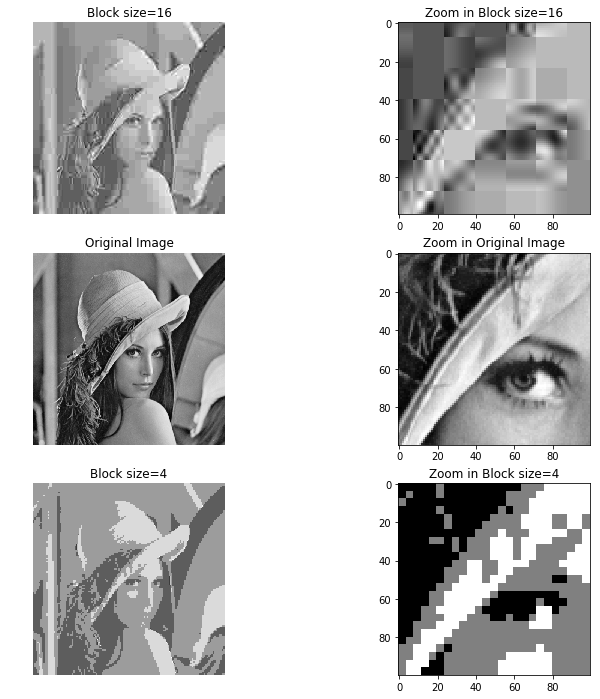

In [9]:

block_size_4 = jpeg2im(im2jpeg(img, block_size = 4, quality=25), block_size = 4, quality=25)
block_size_16 = jpeg2im(im2jpeg(img, block_size = 16, quality=25), block_size = 16, quality=25)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
i=0
images={'Original Image':img,'Block size=4':block_size_4,'Block size=16': block_size_16}

while i<3:
    title = random.choice(images.keys())
    ax[i,0].imshow(images[title], cmap='gray'); ax[i,0].set_title(title); ax[i,0].axis('off')
    ax[i,1].imshow(images[title][200:300,200:300],cmap='gray'); ax[i,1].set_title('Zoom in '+title)
    i=i+1
    del images[title]
    

5. Use the following python build in function for JPEG compression:
        result = Image.fromarray((img).astype(np.uint8))
        result.save(Compressed_File_Name,"JPEG",optimize=True,quality= Your_quality)
   * Compress your image by using this function.
   * Load and show the compressed image. 
   * Pay attention for the compressed image size that as saved on youwith respect to the origonal image size.
   * Plot the compressed imag with quality of: 4, 10, 60.
   
   
__Note__: The 'quality' parameter is different here from the 'quality' parameter that we used in this lab implementation 5. 

Text(0.5,1,'lena quality 60')

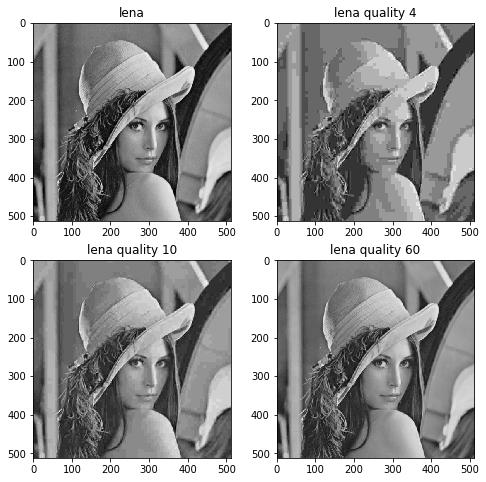

In [10]:
qualities = [4,10,60]
array_of_lennas = []
result = Image.fromarray((img).astype(np.uint8))
result.save('original_lena.png',"PNG",optimize=True)
lena = io.imread('original_lena.png')
for i in range(0,3):
    result.save('lena'+str(i)+'.jpg',"JPEG",optimize=True,quality= qualities[i])
    array_of_lennas.append(io.imread('lena'+str(i)+'.jpg'))
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))


ax[0,0].imshow(lena,cmap='gray')
ax[0,0].set_title('lena')


ax[0,1].imshow(array_of_lennas[0],cmap='gray')
ax[0,1].set_title('lena quality 4')


ax[1,0].imshow(array_of_lennas[1],cmap='gray')
ax[1,0].set_title('lena quality 10')


ax[1,1].imshow(array_of_lennas[2],cmap='gray')
ax[1,1].set_title('lena quality 60')